In [1]:
import good_morning as gm
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from pandas_datareader import data as pdr
import fix_yahoo_finance as yf
import urllib.request
import re
import sys
from pandas.tseries.offsets import *
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV

sns.set()


yf.pdr_override()

In [2]:
def get_tickers():
    file = open('ticker.txt', 'r')
    tickers = []
    pattern = re.compile('^[A-Z]{2,}')
    
    for index,line in enumerate(file):
        if (len(str.split(line)) == 1) and re.match(pattern,line):
            tickers.append(str.strip(line))
    return tickers

In [3]:
## Getting data from stockrow instead - has quarterly data which is better - more data points
def get_stock_data(tickers):
    
    #for each ticker get income info for quarterly, 12 month trailing, metrics for both, quarterly growth
    for ticker in tickers:
        
        try:
            #get data from stockrow, rename columns to avoid errors on join
            url_fq = "https://stockrow.com/api/companies/{}/financials.xlsx?dimension=MRQ&section=Income%20Statement&sort=desc".format(ticker)
            response = urllib.request.urlopen(url_fq)
            income_q = pd.read_excel(response) 
            income_q = income_q.T
            income_q.columns  = income_q.columns.str.lower().str.replace(' ','_') + '_q'

            url_ft = "https://stockrow.com/api/companies/{}/financials.xlsx?dimension=MRT&section=Income%20Statement&sort=desc".format(ticker)
            response = urllib.request.urlopen(url_ft)
            income_t = pd.read_excel(response) 
            income_t = income_t.T
            income_t.columns  = income_t.columns.str.lower().str.replace(' ','_') + '_t'

            url_mq = "https://stockrow.com/api/companies/{}/financials.xlsx?dimension=MRQ&section=Metrics&sort=desc".format(ticker)
            response = urllib.request.urlopen(url_mq)
            metrics_q = pd.read_excel(response)
            metrics_q = metrics_q.T
            metrics_q.columns  = metrics_q.columns.str.lower().str.replace(' ','_') + '_q'

            url_mt = "https://stockrow.com/api/companies/{}/financials.xlsx?dimension=MRT&section=Metrics&sort=desc".format(ticker)
            response = urllib.request.urlopen(url_mt)
            metrics_t = pd.read_excel(response)
            metrics_t = metrics_t.T
            metrics_t.columns  = metrics_t.columns.str.lower().str.replace(' ','_') + '_t'

            url_gq = 'https://stockrow.com/api/companies/{}/financials.xlsx?dimension=MRQ&section=Growth&sort=desc'.format(ticker)
            response = urllib.request.urlopen(url_gq)
            growth_q = pd.read_excel(response)
            growth_q = growth_q.T
            growth_q.columns= growth_q.columns.str.lower().str.replace(' ','_') + '_q'

            #innner join of all data
            joined_df = growth_q.join([income_q,income_t,metrics_q,metrics_t], how = 'inner')
            joined_df['ticker'] = ticker


            #get last 50 days of stock data for each date in df to get closing price on day, 50 day moving average
            price_info = []
            for date in joined_df.index:
                s = date - np.timedelta64(50,'D')
                price_info.append(pdr.get_data_yahoo(ticker,start = s, end = date))

            #get closing prices, 50 day moving averages  
            prices = []
            sma_50 = []
            for df in price_info:
                sma_50.append(df['Close'].mean())
                prices.append(df.iloc[-1]['Close'])

            joined_df['price'] = prices
            joined_df['sma_50'] = sma_50
            joined_df['market_cap'] = joined_df['price'] * joined_df['weighted_average_shares_q']


            #write data to csv
            joined_df.to_csv('Data/{}_data.csv'.format(ticker))
        except:
            print("Error for: ",ticker,"Error is: ",sys.exc_info()[0])

In [4]:
#read csvs into one big dataframe
def get_csvs(tickers):
    stock_dfs = []
    for ticker in tickers:
        try:
            stock_dfs.append(pd.read_csv('Data/{}_data.csv'.format(ticker)))
        except:
            pass
    
    return pd.concat(stock_dfs)

In [5]:
def clean_df(df):
    #reindex df
    df.dropna(axis = 0,how = 'all',inplace = True)
    df.index = range(len(df))
    df.rename(columns = {'Unnamed: 0':'date'},inplace = True)
    df['date'] = pd.to_datetime(df['date'])
    
    #delete columns with more than 10 % null values
    df = df.loc[:, df.isnull().mean() < .1]
    
    #get price one year ahead, get return to use as Y
    df['future_price'] = df.groupby('ticker')['price'].shift(4)
    df['return'] = (df['future_price'] - df['price']) / df['price']
    
    #remove return outliers - possibly distorted to errors or stock splits
    df = df[df['return'].abs() < 20]
    
    df['good_return'] = df['return'] > 0.10
    df['good_return'] = pd.get_dummies(df['good_return'])
    return df

In [6]:
tickers = get_tickers()
#tickers = tickers[4610:]
#get_stock_data(tickers)

In [7]:
big_df = get_csvs(tickers)
big_df = clean_df(big_df)

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [8]:
def market_cap_dfs(df):
    return df[df['market_cap'] > 10000000000], df[(df['market_cap'] < 10000000000) & (df['market_cap'] > 2000000000)], df[df['market_cap'] < 2000000000]

In [9]:
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import normalize
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier

# regression - use random forest regressor
def forest_regression(df):
    df.dropna(axis = 0,how = 'any',inplace = True)
    cols = ['date','ticker','return','future_price','good_return']
    X = df.drop(cols,axis = 1)
    X_norm = normalize(X)
    y = df['return']
    X_train,X_test,y_train,y_test = train_test_split(X_norm,y,random_state = 42)
    
    forest = RandomForestRegressor(n_estimators = 100, min_samples_leaf = 2)
    forest.fit(X_train,y_train)
    return forest, X_test,y_test

#Classification - get best random forest model with gridsearch
def forest_classification(df):
    df.dropna(axis = 0,how = 'any',inplace = True)
    cols = ['date','ticker','return','future_price','good_return']
    X = df.drop(cols,axis = 1)
    X_norm = normalize(X)
    y = df['good_return']
    X_train,X_test,y_train,y_test = train_test_split(X_norm,y,random_state = 42)
    
    #classifier
    forest = RandomForestClassifier(n_estimators = 150)
    forest.fit(X_train,y_train)

    print("Score: ",forest.score(X_test,y_test))
    
    return forest, X_test, y_test

//anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [10]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation

def neural_net(df):
    df.dropna(axis = 0,how = 'any',inplace = True)
    cols = ['date','ticker','return','future_price','good_return']
    X = df.drop(cols,axis = 1)
    X_norm = normalize(X)
    y = df['good_return']
    X_train,X_test,y_train,y_test = train_test_split(X_norm,y,random_state = 42)
    
    model = Sequential([Dense(32,input_dim = X_train.shape[1]),Activation('relu'),Dropout(0.5),Dense(80),Activation('relu'),Dropout(0.5),Dense(1),Activation('sigmoid')])
    model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
    model.fit(X_train,y_train,epochs = 50,batch_size = 128)
    score = model.evaluate(X_test, y_test, batch_size=128)
    return model,score,X_test,y_test
    

Using TensorFlow backend.


In [83]:
def nn_regression(df):
    df.dropna(axis = 0,how = 'any',inplace = True)
    cols = ['date','ticker','return','future_price','good_return']
    X = df.drop(cols,axis = 1)
    X_norm = normalize(X)
    y = df['good_return']
    X_train,X_test,y_train,y_test = train_test_split(X_norm,y,random_state = 42)
    
    model = Sequential([Dense(32,input_dim = X_train.shape[1]),Activation('relu'),Dropout(0.5),Dense(80),Activation('relu'),Dropout(0.5)])
    model.add(Dense(1, kernel_initializer='normal',activation = 'linear'))
                        
    model.compile(optimizer='rmsprop',loss='mse')
    model.fit(X_train,y_train,epochs = 50,batch_size = 128)
    score = model.evaluate(X_test, y_test, batch_size=128)
    return model,score,X_test,y_test

In [58]:
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB

def pca_nb(df):
    df.dropna(axis = 0,how = 'any',inplace = True)
    cols = ['date','ticker','return','future_price','good_return']
    X = df.drop(cols,axis = 1)
    y = df['good_return']
    X_norm = normalize(X)
    X_train,X_test,y_train,y_test = train_test_split(X_norm,y,random_state = 42)
    
    pca = PCA(n_components = 2)
    pca.fit(X_train)
    xt_train = pca.transform(X_train)
    xt_test = pca.transform(X_test)
    
    nb = GaussianNB()
    nb.fit(xt_train,y_train)
    
    print("Score: ",nb.score(xt_test,y_test)) 
    return nb, xt_test,y_test

In [12]:
rforest_all,xt_all,yt_all = forest_regression(big_df)
large,mid,small = market_cap_dfs(big_df)
rforest_large, xt_large, yt_large = forest_regression(large)
rforest_mid, xt_mid, yt_mid = forest_regression(mid)
rforest_small, xt_small, yt_small = forest_regression(small)

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Randorm Forest Results

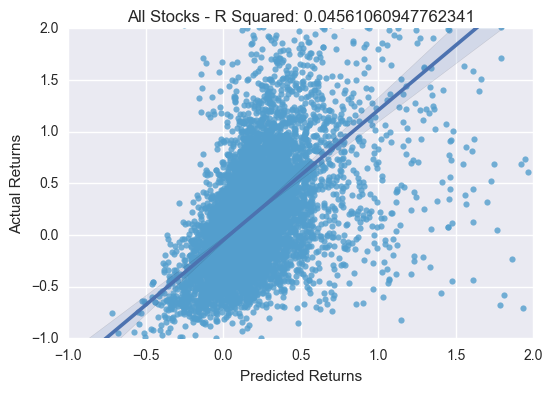

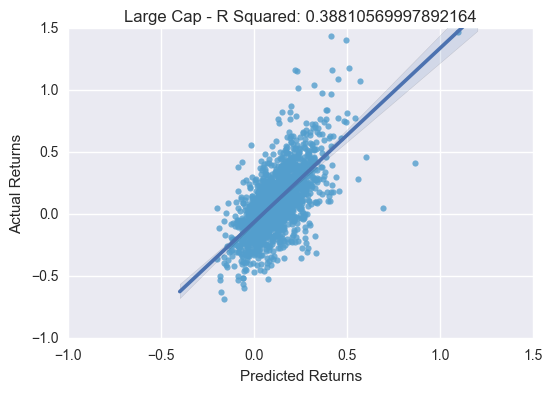

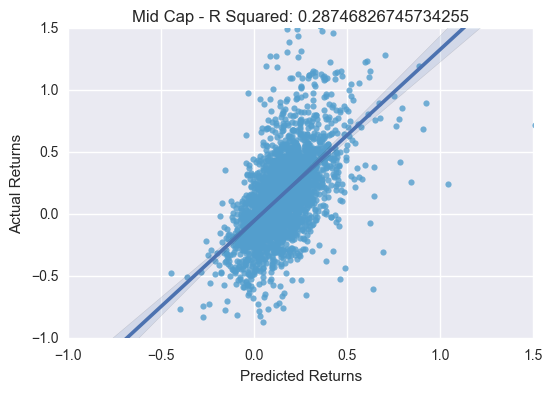

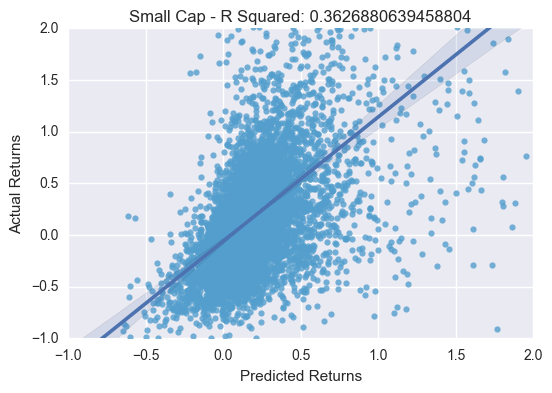

In [13]:
plt.figure(1)
sns.regplot(rforest_all.predict(xt_all),yt_all,'o',scatter_kws = {'color':sns.color_palette("Blues")[3]})
plt.title("All Stocks - R Squared: {}".format(rforest_large.score(xt_all,yt_all)))
axes = plt.gca()
plt.ylabel("Actual Returns")
plt.xlabel("Predicted Returns")
axes.set_xlim(-1,2)
axes.set_ylim(-1,2)

plt.figure(2)
sns.regplot(rforest_large.predict(xt_large),yt_large,'o',scatter_kws = {'color':sns.color_palette("Blues")[3]})
plt.title("Large Cap - R Squared: {}".format(rforest_large.score(xt_large,yt_large)))
axes = plt.gca()
plt.ylabel("Actual Returns")
plt.xlabel("Predicted Returns")
axes.set_xlim(-1,1.5)
axes.set_ylim(-1,1.5)

plt.figure(3)
sns.regplot(rforest_mid.predict(xt_mid),yt_mid,'o',scatter_kws = {'color':sns.color_palette("Blues")[3]})
plt.title("Mid Cap - R Squared: {}".format(rforest_mid.score(xt_mid,yt_mid)))
axes = plt.gca()
plt.ylabel("Actual Returns")
plt.xlabel("Predicted Returns")
axes.set_xlim(-1,1.5)
axes.set_ylim(-1,1.5)

plt.figure(4)
sns.regplot(rforest_small.predict(xt_small),yt_small,'o',scatter_kws = {'color':sns.color_palette("Blues")[3]})
plt.title("Small Cap - R Squared: {}".format(rforest_small.score(xt_small,yt_small)))
axes = plt.gca()
plt.ylabel("Actual Returns")
plt.xlabel("Predicted Returns")
axes.set_xlim(-1,2)
axes.set_ylim(-1,2)
plt.show()

Not surprisingly, trying to predict stock returns across all stocks was not very succesful. However when breaking up the stocks by market cap, we see a large improvement in the performance of our models.

## Classification

In this next section, we use models to classify the performance of stocks, with stocks returning greater than 10% (slightly above the historical S&P performance) classified as 'good' stocks.

In [85]:
nn_model,nn_score,nxtest,nytest = neural_net(big_df)

Epoch 1/50
43927/43927 [==============================] - 2s 39us/step - loss: 0.6918 - acc: 0.5193
Epoch 2/50
43927/43927 [==============================] - 1s 29us/step - loss: 0.6897 - acc: 0.5322
Epoch 3/50
43927/43927 [==============================] - 1s 28us/step - loss: 0.6885 - acc: 0.5386
Epoch 4/50
43927/43927 [==============================] - 1s 28us/step - loss: 0.6869 - acc: 0.5447
Epoch 5/50
43927/43927 [==============================] - 1s 28us/step - loss: 0.6861 - acc: 0.5422
Epoch 6/50
43927/43927 [==============================] - 1s 28us/step - loss: 0.6855 - acc: 0.5458
Epoch 7/50
43927/43927 [==============================] - 1s 28us/step - loss: 0.6844 - acc: 0.5508
Epoch 8/50
43927/43927 [==============================] - 1s 29us/step - loss: 0.6841 - acc: 0.5519
Epoch 9/50
43927/43927 [==============================] - 1s 28us/step - loss: 0.6834 - acc: 0.5535
Epoch 10/50
43927/43927 [==============================] - 1s 28us/step - loss: 0.6829 - acc: 0.5574

In [80]:
nb_clfm,nb_xtest,nb_ytest = pca_nb(big_df)
lnb_clfm,lnb_xtest,lnb_ytest = pca_nb(large)
mnb_clfm,mnb_xtest,mnb_ytest = pca_nb(mid)
snb_clfm,snb_xtest,snb_ytest = pca_nb(small)

Score:  0.529946049307
Score:  0.523137697517


//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Score:  0.545344619105
Score:  0.539732329569


In [16]:
cforest_all, cxt_all, cyt_all = forest_classification(big_df)
cforest_large, cxt_large, cyt_large = forest_classification(large)
cforest_mid, cxt_mid, cyt_mid = forest_classification(mid)
cforest_small, cxt_small, cyt_small = forest_classification(small)

Score:  0.682305538483


//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Score:  0.718397291196


//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Score:  0.691958887545


//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Score:  0.683082392304


In [17]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

#get roc data to graph roc curve, compute auroc
def roc_curve_and_score(model,x_test,y_test):
    prediction_probs = model.predict_proba(x_test)[:,1]
    false_positive_rate, true_positive_rate, _ = roc_curve(y_test, prediction_probs)
    auroc = roc_auc_score(y_test,prediction_probs)
    return false_positive_rate,true_positive_rate,auroc

In [76]:
nn_probs = nn_model.predict(nxtest).ravel()
nn_fpr,nn_tpr,_ = roc_curve(nytest,nn_probs)
nn_auroc = roc_auc_score(nytest,nn_probs)

## Model Analysis

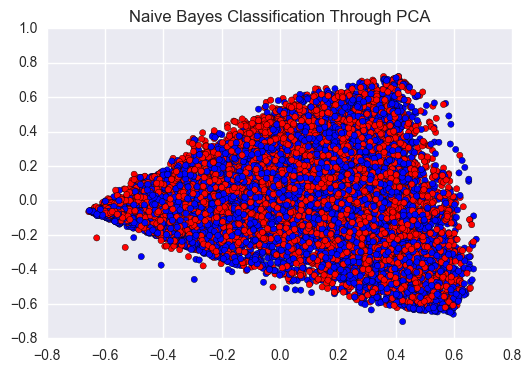

In [68]:
## Naive Bayes Contour Map
from matplotlib.colors import ListedColormap

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
plt.scatter(nb_xtest[:,0],nb_xtest[:,1],c = nb_ytest,cmap=cm_bright, edgecolors='k')
plt.title('Naive Bayes Classification Through PCA')
plt.show()

## ROC Analysis For Classifiers

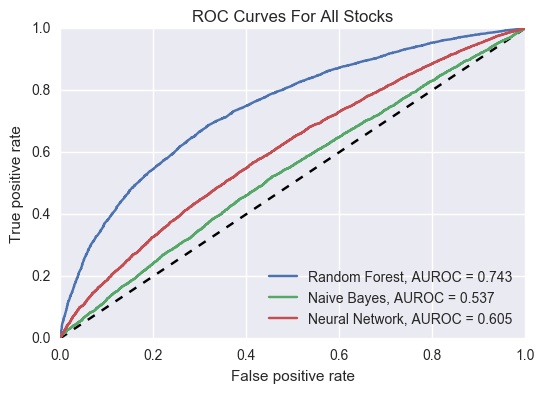

In [77]:
##ROC Curves for all stocks, random forest and naive bayes methods

rf_fpr,rf_tpr,rf_auroc = roc_curve_and_score(cforest_all,cxt_all,cyt_all)
nb_fpr,nb_tpr,nb_auroc = roc_curve_and_score(nb_clfm,nb_xtest,nb_ytest)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(rf_fpr, rf_tpr, label = 'Random Forest, AUROC = {}'.format(rf_auroc.round(3)))
plt.plot(nb_fpr, nb_tpr, label = 'Naive Bayes, AUROC = {}'.format(nb_auroc.round(3)))
plt.plot(nn_fpr, nn_tpr, label = 'Neural Network, AUROC = {}'.format(nn_auroc.round(3)))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curves For All Stocks')
plt.legend(loc = 'best')
plt.show()



As we can see, the random forest performed the best, followed by the neural network, and then the naive bayes model, which only performed slightly better than random. This is in line with what I expected, as the size of the dataset is not large enough for a neural network to perform to its maximum capabilities. Considering this data only goes back to 2008, it would be interesting to see this analysis done with a dataset going back substantially further. 

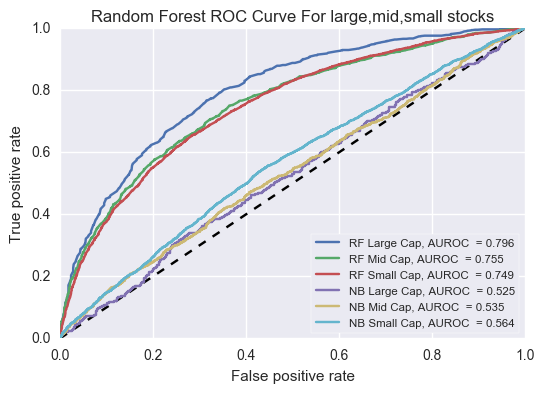

In [61]:
##ROC Curves for different caps, random forest and naive bayes methods

lrf_fpr,lrf_tpr,lrf_auroc = roc_curve_and_score(cforest_large,cxt_large,cyt_large)
mrf_fpr,mrf_tpr,mrf_auroc = roc_curve_and_score(cforest_mid,cxt_mid,cyt_mid)
srf_fpr,srf_tpr,srf_auroc = roc_curve_and_score(cforest_small,cxt_small,cyt_small)

lnb_fpr,lnb_tpr,lnb_auroc = roc_curve_and_score(lnb_clfm,lnb_xtest,lnb_ytest)
mnb_fpr,mnb_tpr,mnb_auroc = roc_curve_and_score(mnb_clfm,mnb_xtest,mnb_ytest)
snb_fpr,snb_tpr,snb_auroc = roc_curve_and_score(snb_clfm,snb_xtest,snb_ytest)
plt.figure(2)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(lrf_fpr, lrf_tpr,label = "RF Large Cap, AUROC  = {}".format(lrf_auroc.round(3)))
plt.plot(mrf_fpr, mrf_tpr,label = "RF Mid Cap, AUROC  = {}".format(mrf_auroc.round(3)))
plt.plot(srf_fpr, srf_tpr,label = "RF Small Cap, AUROC  = {}".format(srf_auroc.round(3)))
plt.plot(lnb_fpr, lnb_tpr,label = "NB Large Cap, AUROC  = {}".format(lnb_auroc.round(3)))
plt.plot(mnb_fpr, mnb_tpr,label = "NB Mid Cap, AUROC  = {}".format(mnb_auroc.round(3)))
plt.plot(snb_fpr, snb_tpr,label = "NB Small Cap, AUROC  = {}".format(snb_auroc.round(3)))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Random Forest ROC Curve For large,mid,small stocks')
plt.legend(loc = 'best',frameon = True,fontsize = 'x-small')
plt.show()


When seperating the stocks by market capitalization, we see roughly the same results as before, with a slight improvement in the performance of the random forest model, especially for large cap stocks. 